In [1]:
import os
import sys
import time

from data_generator import NeedleData
from model import CNNModel
from project.settings import intermediate_dir
from cnn import unet_1, loss
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu1')

if __name__ == '__main__':
    data_dir = os.path.join(intermediate_dir, "numpy")
    model, model_id, padding_axis1, padding_axis2 = unet_1.model(l2_constant=0, lr=1e-6)
    ds = NeedleData(padding_axis1, padding_axis2)
    cnn = CNNModel(data_streamer= ds, model= model)
    uid = "unet_1br=2_lr=1e-4_bs=128_flipping"
    testing_dice_loss, testing_dice_coef, testing_prediction, testing_mask = cnn.predict_test(uid=uid, split_num=1, batch_size=128)
    validation_dice_loss, validation_dice_coef, validation_prediction, validation_mask= cnn.predict_validation(uid=uid, split_num=1, batch_size=128)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla P100-PCIE-16GB (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/home/administrator/ProstateNeedleFinder/Prostate-Needle-Finder/cnn/unet_1.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="valid", kernel_regularizer=<keras.reg...)`
  conv1 = Convolution2D(32, 3, 3, activation='relu', W_regularizer=l2(l2_constant), border_mode='valid')(inputs)
/home/administrator/ProstateNeedleFinder/Prostate-Needle-Finder/cnn/unet_1.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="valid", kernel_regularizer=<keras.r

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 44, 200)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 42, 198)   320                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 40, 196)   9248                                         
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 40, 98)    0                                            
___________________________________________________________________________________________

In [2]:
print("Testing Loss: ", testing_dice_loss, "Testing Dice: ", testing_dice_coef)
print("Validation Loss: ", validation_dice_loss, "Validation Dice: ", validation_dice_coef)
print("Validation Dice Collection Wise: ", loss.dice_coef_category_numpy_collectionwise(validation_mask, validation_prediction))
print("Testing Dice Collection Wise: ", loss.dice_coef_category_numpy_collectionwise(testing_mask, testing_prediction))
print("Validation Dice Slice Wise: ", loss.dice_coef_category_numpy_slicewise(validation_mask, validation_prediction))
print("Testing Dice Collection Wise: ", loss.dice_coef_category_numpy_slicewise(testing_mask, testing_prediction))

Testing Loss:  0.619897597807 Testing Dice:  0.382725229073
Validation Loss:  0.625388185579 Validation Dice:  0.374655793523
Validation Dice Collection Wise:  0.404364569961
Testing Dice Collection Wise:  0.484694982032
Validation Dice Slice Wise:  0.921509319699
Testing Dice Collection Wise:  0.934309154655


In [13]:
import numpy as np
prediction_sqzd = np.squeeze(prediction)
mask_sqzd = np.squeeze(mask)
VOLNUM = 7

pred_img = []
mask_img = []
pred_categ_img = []
for i in range(len(prediction_sqzd)//180):
    pred_img.append(prediction_sqzd[i*180:i*180+180])
    mask_img.append(mask_sqzd[i*180:i*180+180])
    pred_categ_img.append(prediction_sqzd[i*180:i*180+180] > 0.5)
print("Number of Prediction Volumes: ", len(pred_img))
single_pred = pred_img[VOLNUM]
single_pred_categ = pred_categ_img[VOLNUM]
single_mask = mask_img[VOLNUM]
print(np.unique(single_pred, return_counts=True))
print(np.unique(single_pred_categ, return_counts=True))

Number of Prediction Volumes:  77
(array([  0.00000000e+00,   1.17573678e-38,   1.17630893e-38, ...,
         9.99997020e-01,   9.99999642e-01,   1.00000000e+00], dtype=float32), array([591585,      1,      1, ...,      1,      2,     66]))
(array([False,  True], dtype=bool), array([691114,     86]))


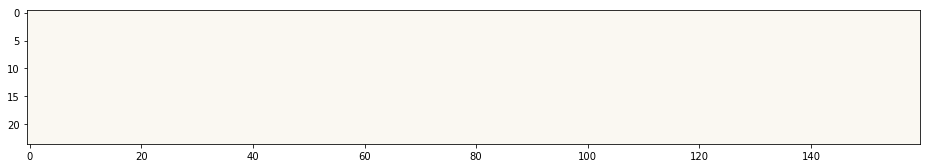

In [12]:
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline

def view_img(sample):
    fig = plt.figure(figsize=(16, 16));
    pred = plt.imshow(single_pred_categ[sample],cmap=plt.cm.Greens, interpolation='none')
    mask = plt.imshow(single_mask[sample],cmap=plt.cm.Reds, interpolation='none', alpha=0.5)
    
interact(view_img, sample=(0,single_pred_categ.shape[0]-1))
    